In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train = pd.read_csv("data-preCO-train.csv")
test = pd.read_csv("data-preCO-test.csv")
train.head()

,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,target
0,0.523888,0.126156,0.184294,0.360514,0.108622,0.311024,0.328694,0.513040,0.454654,0.304153,0.509628,0.287117,1
1,0.474090,0.094197,0.145214,0.310850,0.065852,0.360796,0.266509,0.453125,0.326382,0.297419,0.494544,0.270951,0
2,0.554759,0.074012,0.138933,0.302367,0.084861,0.346500,0.331655,0.451214,0.370588,0.265993,0.575096,0.283352,1
3,0.535281,0.067283,0.142566,0.307292,0.112695,0.326168,0.355345,0.464366,0.426741,0.245791,0.652439,0.301626,1
4,0.459390,0.042893,0.099931,0.245588,0.084861,0.374034,0.337578,0.422212,0.386228,0.249158,0.646983,0.302669,0


In [4]:
target = train["target"]
train.drop(["target"], axis=1, inplace=True)

###### 先使用简单交叉验证， 之后会用K折交叉验证重新测试

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42, shuffle=True)

In [6]:
unique_labels = np.unique(y_train)
print("Unique labels in y_train:", unique_labels)

Unique labels in y_train: [0 1]


In [10]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1], )))
# model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
history = model.fit(X_train, y_train, epochs=300, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/300
43/43 [==============================] - 0s 3ms/step - loss: 0.5931 - accuracy: 0.7540 - val_loss: 0.4599 - val_accuracy: 0.8775
Epoch 2/300
43/43 [==============================] - 0s 1ms/step - loss: 0.3343 - accuracy: 0.9014 - val_loss: 0.2520 - val_accuracy: 0.9077
Epoch 3/300
43/43 [==============================] - 0s 1ms/step - loss: 0.2292 - accuracy: 0.9123 - val_loss: 0.2201 - val_accuracy: 0.9173
Epoch 4/300
43/43 [==============================] - 0s 1ms/step - loss: 0.2098 - accuracy: 0.9190 - val_loss: 0.2005 - val_accuracy: 0.9247
Epoch 5/300
43/43 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.9206 - val_loss: 0.1972 - val_accuracy: 0.9277
Epoch 6/300
43/43 [==============================] - 0s 1ms/step - loss: 0.1987 - accuracy: 0.9252 - val_loss: 0.1918 - val_accuracy: 0.9284
Epoch 7/300
43/43 [==============================] - 0s 1ms/step - loss: 0.1961 - accuracy: 0.9234 - val_loss: 0.1889 - val_accuracy: 0.9306
Epoch 8/300
4

In [8]:
import matplotlib.pyplot as plt

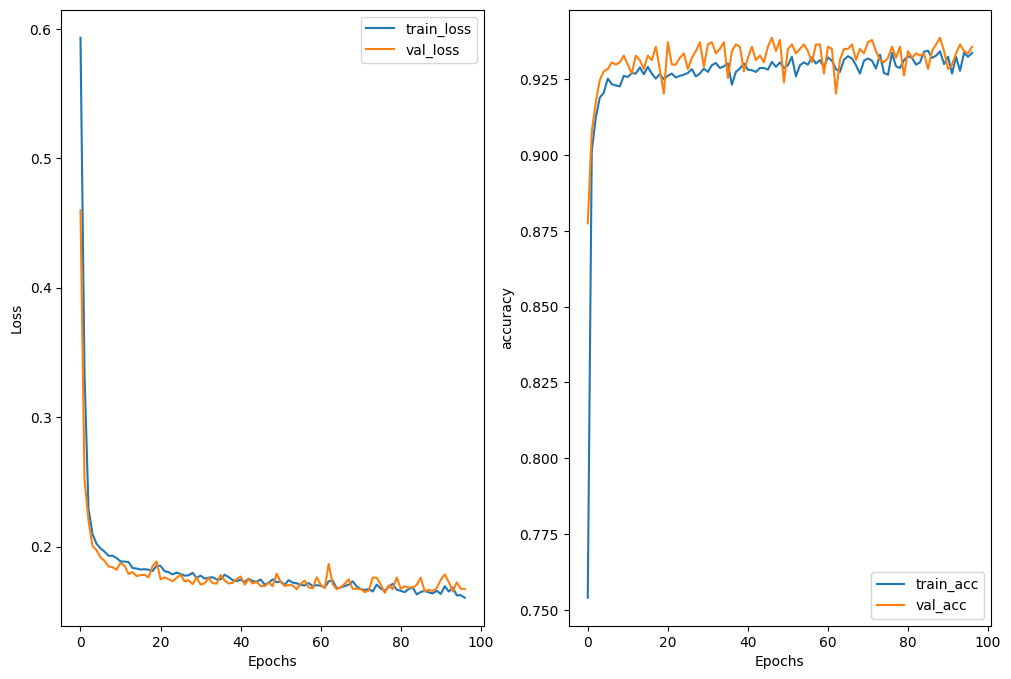

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

###### 我们可以看到，在我们的疯狂炼丹下， 准确率只达到了90%, 坏消息是无论是增加层数还是隐藏节点都不会提高准确率，但是目前并没有发生过拟合.
###### 说明此时训练模型遇到瓶颈，需要对数据进行新的变化，记下来我们将对数据进行多项式变换

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

In [13]:
import numpy as np
import pandas as pd

In [15]:
X = pd.read_csv("data-preCO-train.csv")
y = X["target"]
X.drop(["target"], axis=1, inplace=True)

In [16]:
X.shape, y.shape

((6773, 12), (6773,))

In [17]:
poly_X = poly.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(poly_X, y, test_size=0.2, random_state=42, shuffle=True)

In [19]:
X_train.shape, y_train.shape

((5418, 91), (5418,))

In [82]:
model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(poly_X.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dense(128, activation='relu', input_shape=(poly_X.shape[1],), kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(16, activation="relu", kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation="relu", kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(poly_X, y, epochs=500, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/500
53/53 [==============================] - 1s 5ms/step - loss: 3.1501 - accuracy: 0.8509 - val_loss: 1.7684 - val_accuracy: 0.9181
Epoch 2/500
53/53 [==============================] - 0s 3ms/step - loss: 1.2141 - accuracy: 0.9173 - val_loss: 0.8304 - val_accuracy: 0.9026
Epoch 3/500
53/53 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.9122 - val_loss: 0.5415 - val_accuracy: 0.9070
Epoch 4/500
53/53 [==============================] - 0s 4ms/step - loss: 0.4805 - accuracy: 0.9158 - val_loss: 0.4306 - val_accuracy: 0.9240
Epoch 5/500
53/53 [==============================] - 0s 4ms/step - loss: 0.4117 - accuracy: 0.9170 - val_loss: 0.3824 - val_accuracy: 0.9269
Epoch 6/500
53/53 [==============================] - 0s 4ms/step - loss: 0.3808 - accuracy: 0.9135 - val_loss: 0.3697 - val_accuracy: 0.9100
Epoch 7/500
53/53 [==============================] - 0s 3ms/step - loss: 0.3601 - accuracy: 0.9166 - val_loss: 0.3687 - val_accuracy: 0.8982
Epoch 8/500
5

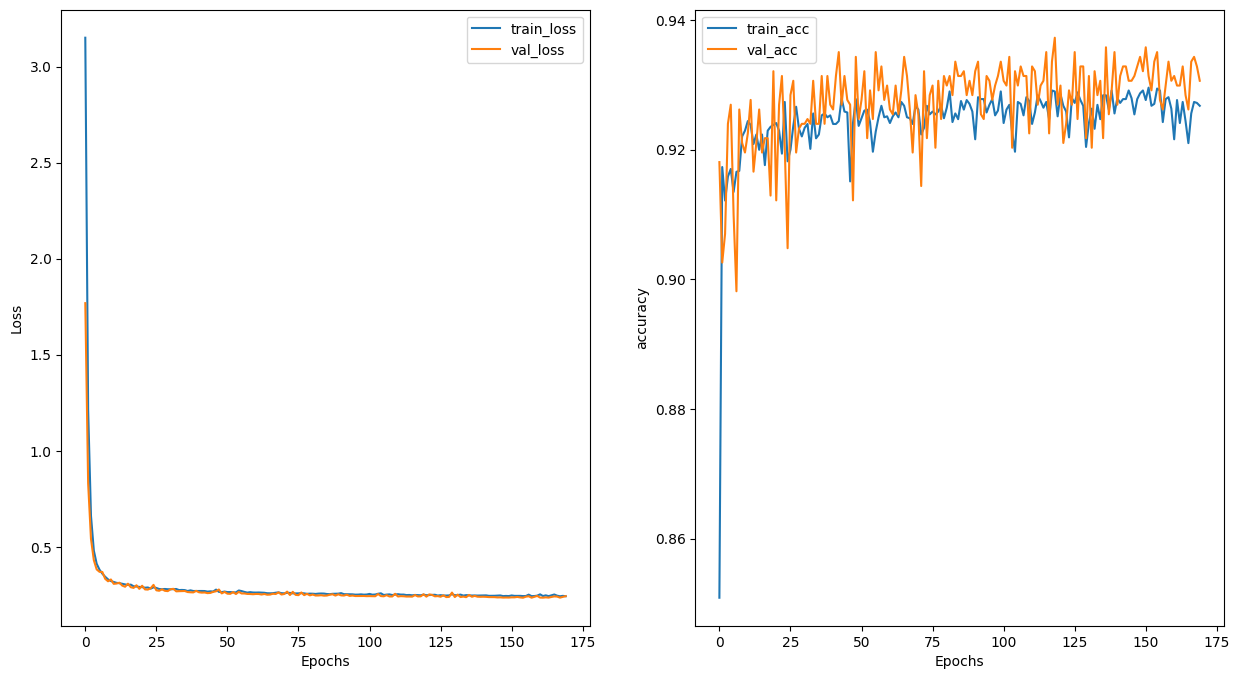

In [83]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [84]:
predict = (model.predict(X_test) > 0.5).astype('int')
accuracy_score(y_test.values, predict)

43/43 [==============================] - 0s 739us/step


0.9350553505535055

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

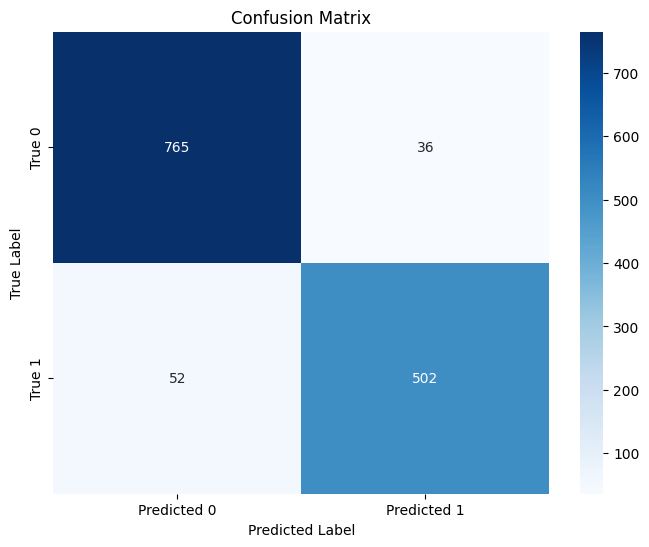

In [85]:
cm = confusion_matrix(y_test, predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [81]:
model.save("classification_model.h5")

In [73]:
model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(poly_X.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dense(128, activation='relu', input_shape=(poly_X.shape[1],)))
# model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation="relu", kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(poly_X, y, epochs=500, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/500
53/53 [==============================] - 1s 3ms/step - loss: 0.3762 - accuracy: 0.8405 - val_loss: 0.2073 - val_accuracy: 0.9196
Epoch 2/500
53/53 [==============================] - 0s 1ms/step - loss: 0.2092 - accuracy: 0.9167 - val_loss: 0.1995 - val_accuracy: 0.9210
Epoch 3/500
53/53 [==============================] - 0s 1ms/step - loss: 0.1954 - accuracy: 0.9225 - val_loss: 0.1825 - val_accuracy: 0.9314
Epoch 4/500
53/53 [==============================] - 0s 1ms/step - loss: 0.1874 - accuracy: 0.9272 - val_loss: 0.1756 - val_accuracy: 0.9336
Epoch 5/500
53/53 [==============================] - 0s 1ms/step - loss: 0.1842 - accuracy: 0.9293 - val_loss: 0.1731 - val_accuracy: 0.9365
Epoch 6/500
53/53 [==============================] - 0s 1ms/step - loss: 0.1839 - accuracy: 0.9248 - val_loss: 0.1721 - val_accuracy: 0.9328
Epoch 7/500
53/53 [==============================] - 0s 1ms/step - loss: 0.1825 - accuracy: 0.9272 - val_loss: 0.1796 - val_accuracy: 0.9277
Epoch 8/500
5